# Projet ST7 

In [42]:

import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pathlib
import os
from dateutil import rrule
from datetime import timedelta
from scipy.stats import norm
import datetime
import cvxpy as cp


#Display options from pandas
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)


# US equity Index


In [43]:

#Open the database of the exel file
Mapping = pd.read_excel("DataProjets.xlsx","Mapping", index_col="Sedol")
Mapping_Sector = pd.read_excel("DataProjets.xlsx","Mapping_Sector" )
MarketCaps = pd.read_excel("DataProjets.xlsx", "MarketCaps", index_col="Date")
Sector = pd.read_excel("DataProjets.xlsx", "Sector", index_col="Date")


# change the name of the colunms of Marcket with the Tickers name and set the indices as datetime 
MarketCaps.columns = pd.DataFrame(data=MarketCaps.columns, columns=['Sedol']).merge(Mapping, on='Sedol', how='left')["Tickers"]
MarketCaps.index = pd.to_datetime(MarketCaps.index)

Sector.columns = pd.DataFrame(data=Sector.columns, columns=['Sedol']).merge(Mapping, on='Sedol', how='left')["Tickers"]
Sector.index = pd.to_datetime(Sector.index)


In [44]:

# Load the data into a data base, if a file with the datas already existe this cell open the file, else 
# we download the prices with yfinance

# If the datas already exist
if pathlib.Path(os.getcwd()+ '/Prices_data.csv' ).exists():
    
    #Open the file and define indices as dateTimes
    Prices = pd.read_csv("Prices_data.csv", index_col="Date")
    Prices.index = pd.to_datetime(Prices.index)
    
# if the datas do not exist (download and clean them)
else :
    
    #Download the daily data of the companies
    finance_info = yf.download(Mapping["Tickers"].to_list(), start=MarketCaps.index[0], end=MarketCaps.index[-1])
    
    Prices = finance_info["Close"]
    
    #Save the datas
    Prices.to_csv("Prices_data.csv")
    


In [76]:
# Take data base of prices and clean it
def clean_data(data_set):
    
    #remove the NaN values as follow : 
    # - if there is no price for a day, replace the value whith the price of the previous day
    # - if the company has never issued a prize or if it has gone bankrupt: keep the value NaN
    
    clean_dataframe = pd.DataFrame(columns=data_set.columns, index=data_set.index)
    for tickers in data_set.columns:
        
        x = data_set[tickers].last_valid_index()
        clean_dataframe[tickers][:x] = data_set[tickers][:x].fillna(method ='ffill', limit=10)
        
    return clean_dataframe


if pathlib.Path(os.getcwd()+ '/Returns_data.csv' ).exists():
    
    #Open the file and define indices as dateTimes
    Returns = pd.read_csv("Returns_data.csv", index_col="Date")
    Returns.index = pd.to_datetime(Returns.index)
    
# if the datas do not exist (download and clean them)
else :
    
    # Clean the datas and compute the returns

    # Change indices to have datetime type
    Prices.index = pd.to_datetime(Prices.index)

    #Compute the daily returns and drop the first row (NaN row)
    Returns = Prices.pct_change().drop(Prices.index[0])
    
    Returns.to_csv("Returns_data.csv")

    
#remove columns with just NaN value
drop = Returns.columns[Returns.isna().all()]
Returns = Returns.drop(columns=drop)


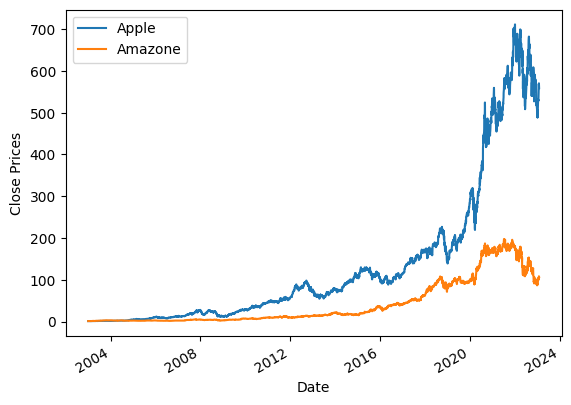

In [82]:

r_apple = (1 + Returns["AAPL"]).cumprod()
r_micro = (1 + Returns["AMZN"]).cumprod()


plt.figure(1)
r_apple.plot(label="Apple")
r_micro.plot(label="Amazone")
plt.legend(loc="best")
plt.ylabel("Close Prices")
plt.savefig("prices.png")

In [46]:

# Compute the weight for all the days

# Add all the day missing in the MarketCaps dataframe
data_concat = pd.concat([Returns["AMZN"],MarketCaps], axis=1)
 
# Remove the column Open_Prices["AMZN"] (keep only the weight)
data_numpy = data_concat.to_numpy()[0:,1:]
weight = pd.DataFrame(data=data_numpy, columns=MarketCaps.columns, index=data_concat.index)

# Change the NaN values of all the days (missing in MarcketCaps) 
# with the value given of the last day of the month
weight.fillna(method='ffill', inplace=True)
weight = weight.loc[Returns.index]
weight = weight.drop(columns=drop)


In [47]:

# Creat a check function to find out if a return is missing and the weight associated is a non zero value
def check(returns, weight):
    problems = dict()
    
    for date in range(len(returns.index)):
        x = returns.iloc[date].isnull()
        y = weight.iloc[date][x]
        z = y.loc[y !=0]
        if len(z):
            problems[returns.index[date]] = z.index
            
    if not len(problems):
        print("No problems")
    else:
        return problems
        

problems = check(Returns, weight)  

In [48]:

# Change weight in order to have a sum equal to 1 despite the problems compute juste before
def change_weight(problems, weight):
    table = pd.DataFrame.copy(weight)
    
    for date in problems.keys():
        row = table.loc[date]
        alpha  =  row[problems[date]].sum()
        row[problems[date]] = 0
        table.loc[date] = row * (1 - alpha)**-1   
    return table


new_weight = change_weight(problems, weight)

In [49]:

# Test 
# Function that test if each row sum to one
def sum_to_one_check(weight):
    error = False
    for date in weight.index:
        if weight.loc[date].sum():
            continue
            
        else:
            print("Problem in row : "  + str(date))
            error = True 
    if not error :
        print ("No problems")
    
    
    
check(Returns, new_weight)
sum_to_one_check(new_weight)

No problems
No problems


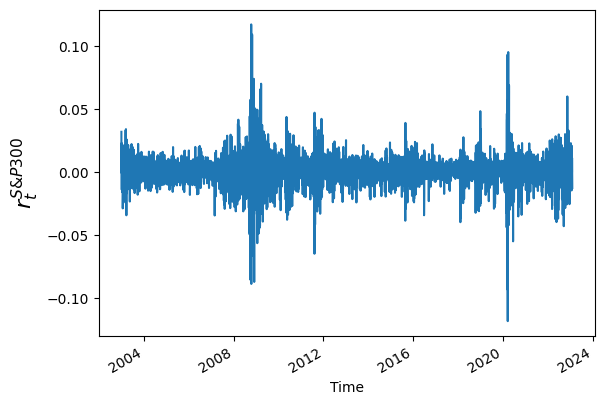

In [50]:

# Compute the US stock market index
r_300 = Returns[weight.columns] * new_weight
daily_r300 = r_300.sum(axis=1)

plt.figure(1)
daily_r300.plot()
plt.xlabel("Time")
plt.ylabel(r'$r^{S&P300}_t$', fontsize=16)
plt.show()


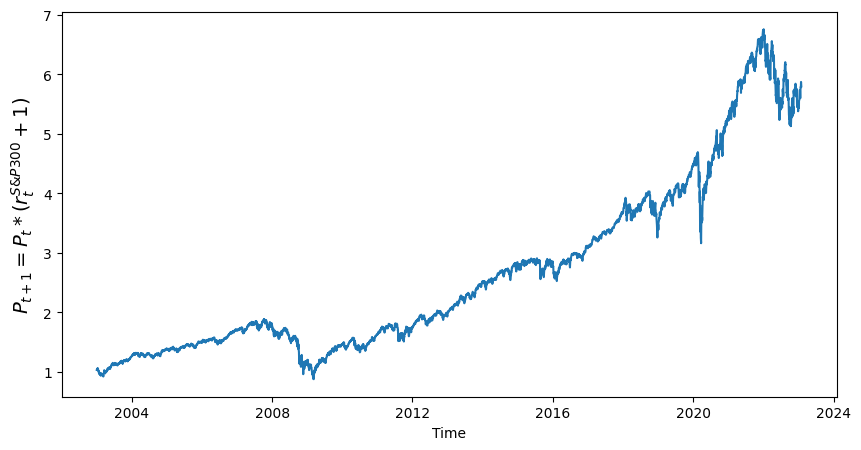

In [51]:
P = (1 + daily_r300.to_numpy()).cumprod()

plt.figure(figsize=(10,5))
plt.plot(r_300.index, P)
plt.xlabel("Time")
plt.ylabel(r'$P_{t+1} = P_t * (r^{S&P300}_t + 1)$', fontsize=14)
plt.show()


# Optimisation 


In [199]:

def returns_period(returns, start_date, end_date, companies):
    # Select the returns of the companies during the period start_date - end_date
    
    returns_per = returns.query("@start_date < index & @end_date >= index").copy()
    return returns_per[companies]


def best_companies(date, index, n):
    #return the n best companies acording to the index
    w = index.query('index <= @date').iloc[-1]
    w = w.sort_values()
    return w.iloc[-n:].index



# create a test to see the matrix that are note SPD 

def test(x):
    if x.isna().any().any():
        return False
    return (np.linalg.eig(x)[0] >= np.zeros(len(x))).all()


def ba(arr1, arr2, func):
    ind1, ind2 = np.meshgrid(range(len(arr1)), range(len(arr2)))
    x = arr1[ind1]
    y = arr2[ind2]
    return func(x, y)

def f(x,y):
    return np.sqrt(x*y)

def RMT_0_estimator(data):
    '''
    input :  pandas dataframe of returns
    output:  RMT0 spectral estimator
    '''
    N = len(data.columns)
    T = len(data)
    cov_data = data.cov().to_numpy()
    correl_data = np.corrcoef(cov_data)
    diag_correl_data = np.diag(np.linalg.eigh(correl_data)[0])
    eigen_vectors = np.linalg.eigh(correl_data)[1]

    lam_1 = diag_correl_data[N-1,N-1]
    sigma_square = 1-lam_1/N
    lam_max = sigma_square*(1+N/T+2*np.sqrt(N/T))

    for i in range(N):
        if diag_correl_data[i,i]<lam_max:
            diag_correl_data[i,i] = 0

    H = eigen_vectors@diag_correl_data@eigen_vectors.T
    C = np.copy(H)
    for i in range(N):
        C[i,i] = 1
    S = C*ba(np.diag(cov_data),np.diag(cov_data),f)
    return S


In [91]:
# Evaluation Methode for a time serie

def evaluation(time_serie, num_fig=0, name = ""):
    start_date = time_serie.index[0]
    end_date = time_serie.index[-1]
    
    returns = time_serie["Returns"]
    
    retruns_pft_tot = (1 + returns).cumprod()
    
  
    # Indicator performance
    T = 252
    mu_hat = returns.mean()
    mu_an = (1+mu_hat) ** 252 - 1

    vol = returns.std()
    vol_an = vol * np.sqrt(T)    
    
    #Sharpe Ratio
    SR = mu_hat/vol

    

    #Maximun Drawdown
    rolling_max = np.maximum.accumulate(retruns_pft_tot)
    dd = -(rolling_max - retruns_pft_tot)/rolling_max
    max_dd = dd.min(axis=0)

    
    #VaR 95% for the last day of the period 
    var = returns.quantile(q=0.05)

    
    if num_fig :
        
        #Plot 
        plt.figure(num_fig,figsize=(15,10))
        
        plt.subplot(221)
        returns.plot( label='returns ' + name)
        plt.ylabel(r'$Returns$', fontsize= 16)
        plt.xlabel('')
        plt.legend(loc = "best")

        plt.subplot(212)
        retruns_pft_tot.plot(label='Total returns ' + name)
        plt.ylabel("Composed prices", fontsize= 16)
        plt.xlabel('')
        plt.legend(loc = "best")

        plt.subplot(222)
        dd.plot(label='Drawdowns indice ' + name)
        plt.xlabel('')
        plt.ylabel(r'Drawdowns', fontsize= 16)
        plt.legend(loc = "best")  
    
    
    #Display result
    time_period = str(start_date.year)+'-'+ str(start_date.month) + " / " + str(end_date.year)+ '-'+ str(end_date.month)
    return [time_period,mu_hat, mu_an, vol, vol_an, SR, max_dd, var]


def display_result(index_name, perf):
    
    columns_tab = ["time_period", r'$\mu$', r'$\mu_{an}$', r'$\sigma$', r'$\sigma_{an}$', "Sharpe_Ratio", "Max_Drawdown", "VaR_95%"]
    df = pd.DataFrame(perf, index = index_name, columns = columns_tab)
    
    df = df.style.format({
    r'$\mu$': '{:,.5%}'.format,
    r'$\mu_{an}$': '{:,.3%}'.format,
    r'$\sigma$': '{:,.3%}'.format,
    r'$\sigma_{an}$': '{:,.3%}'.format,
    'Max_Drawdown': '{:,.3%}'.format,
    'VaR_95%': '{:,.3%}'.format,})

    
    return df   

def plot_Drawdown(returns, num_fig, name=""):
    retruns_pft_tot = (1 + returns).cumprod()
    rolling_max = np.maximum.accumulate(retruns_pft_tot)
    dd = -(rolling_max - retruns_pft_tot)/rolling_max
    
    plt.figure(num_fig)
    dd.plot(label= name)
    plt.xlabel('')
    plt.ylabel(r'Drawdowns', fontsize= 16)
    plt.legend(loc = "best")
    
def plot_returns(returns, num_fig, name=""):
    
    plt.figure(num_fig)
    returns.plot( label= name)
    plt.ylabel(r'$Returns$', fontsize= 16)
    plt.xlabel('')
    plt.legend(loc = "best")
    
def plot_tot_returns(returns, num_fig, name=""):
    
    retruns_pft_tot = (1 + returns).cumprod()
    plt.figure(num_fig)
    retruns_pft_tot.plot(label= name)
    plt.ylabel("Composed prices", fontsize= 16)
    plt.xlabel('')
    plt.legend(loc = "best")
    

## RSP 300 

In [54]:

#Compute a fonction that calculate the returns each when we change the weigth each month 
# choosing n best companies in our weigth

def rsp_compute_returns(returns, start_date, end_date, n): 
    
    result = pd.DataFrame()    
    start_period = start_date
    end_period = start_period + timedelta(days=30)
        
    while start_period < end_date:
        
        companies = best_companies(start_period, new_weight, n)
        
        w = new_weight[companies].query('index <= @start_period').iloc[-1]
        w = w / sum(w)
        
        
        r = returns_period(returns, start_period, end_period, companies)
        
        month_return = (r * w).sum(axis=1)
        
        result = pd.concat([result,month_return])
    
        
        start_period = end_period
        end_period = end_period + timedelta(days=30)
        
    result.index = pd.to_datetime(result.index)
    result.columns = ["Returns"]
    
    return result

            

## MVO

In [62]:
# Makovick 

def W_MVO(mu, Sigma, lmbda, sum_one=True, positive=True):
    
    # Define variables
    w = cp.Variable(len(mu)) # portfolio weights

    # Define objective function
    objective = cp.Maximize(mu @ w - lmbda * cp.quad_form(w, Sigma))

    # Define constraints
    if positive and sum_one:
            constraints = [cp.sum(w) == 1, w >= 0]
    elif positive:
        constraints = [w >= 0]
    elif sum_one :
        constraints = [cp.sum(w) == 1]
    else : 
        constraints = []

    # Solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Return results
    w_opt = w.value
    
    return(w_opt)
    

In [204]:

#Compute a fonction that calculate the returns each when we change the weigth each month 
# choosing n best companies in our weigth

def MVO_compute_returns(returns, start_date, end_date, n, lmbda, sum_one=True, positive=True):
    
    result = pd.DataFrame()    
    start_period = start_date
    end_period = start_period + timedelta(days=30)
        
    while start_period < end_date:
        
        companies = best_companies(start_period, new_weight, n)

        matrice_returns = returns_period(returns, start_period - timedelta(days=730), start_period, companies)
        
        mu = matrice_returns.mean(axis=0).to_numpy()
        Sigma = matrice_returns.corr() * np.dot(np.array([matrice_returns.std()]).T,np.array([matrice_returns.std()]))
        
        #check if Sigma SPD
        if test(Sigma):
            w = W_MVO(mu, Sigma, lmbda, sum_one, positive)
            w = np.round(w*10**10)/10**10
        else : 

            drop = matrice_returns.columns[matrice_returns.isna().any()]
            companies = matrice_returns.columns.drop(drop)
            matrice_returns = matrice_returns[companies]

            mu = matrice_returns.mean(axis=0).to_numpy()
            Sigma = matrice_returns.corr() * np.dot(np.array([matrice_returns.std()]).T,np.array([matrice_returns.std()]))

            w = W_MVO(mu, Sigma, lmbda, sum_one, positive)
            w = np.round(w*10**10)/10**10
            

        
        r = returns_period(returns, start_period, end_period, companies)
        
        month_return = (r * w).sum(axis=1)
        
        result = pd.concat([result,month_return])
    
        
        start_period = end_period
        end_period = end_period + timedelta(days=30)
        
    result.index = pd.to_datetime(result.index)
    result.columns = ["Returns"]
    
    return result
            

,time_period,$\mu$,$\mu_{an}$,$\sigma$,$\sigma_{an}$,Sharpe_Ratio,Max_Drawdown,VaR_95%
rS&P 300,2014-1 / 2016-1,0.00701%,1.783%,0.872%,13.849%,0.008038,-12.455%,-1.516%
MVO,2014-1 / 2016-1,0.03332%,8.757%,2.049%,32.526%,0.016261,-33.910%,-3.537%


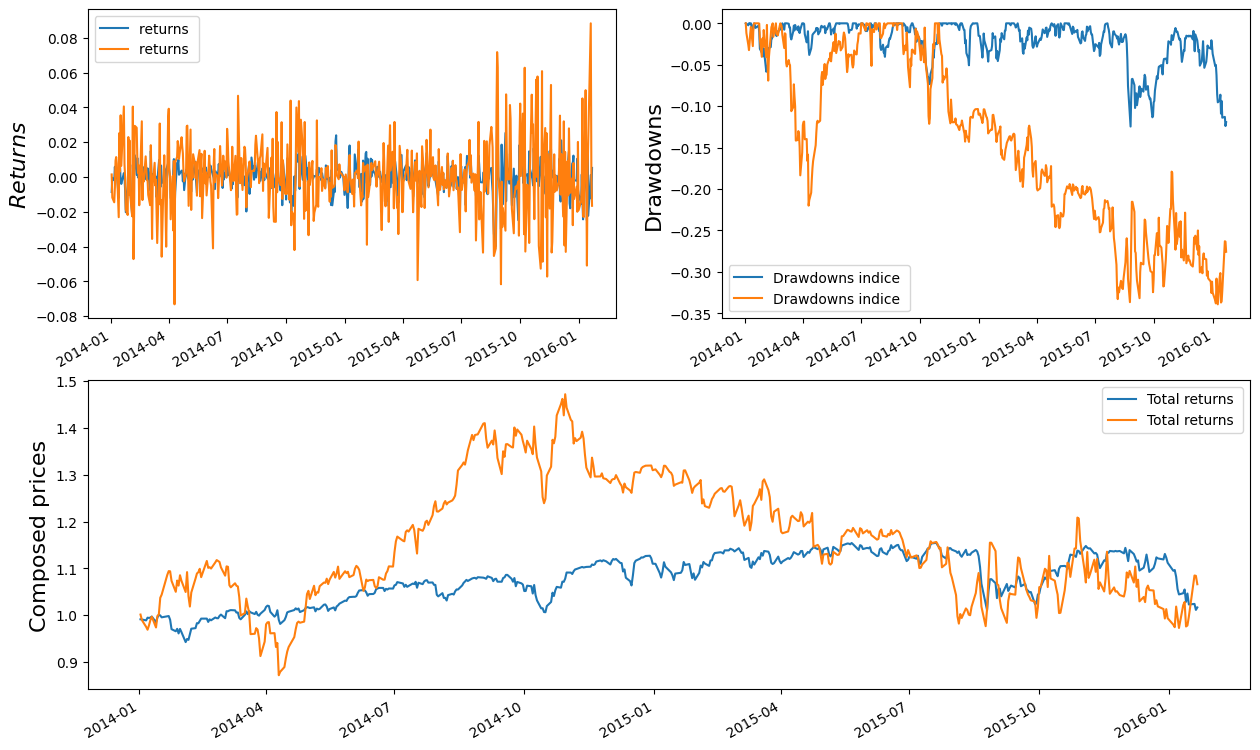

In [206]:
s = pd.Timestamp("2014")
e = s + timedelta(days=730)


r = rsp_compute_returns(Returns, s, e, 530)
r2 = MVO_compute_returns(Returns, s, e, 100, lmbda=1/2)
#r3 = MVO_compute_returns(Returns, s, e, 100, lmbda=10, sum_one=False, positive=False)

ev = evaluation(r, 2)
ev2 = evaluation(r2, 2)
#ev3 = evaluation(r3, 2, "neg")

x = display_result(['rS&P 300', "MVO"], [ev, ev2]) 
x

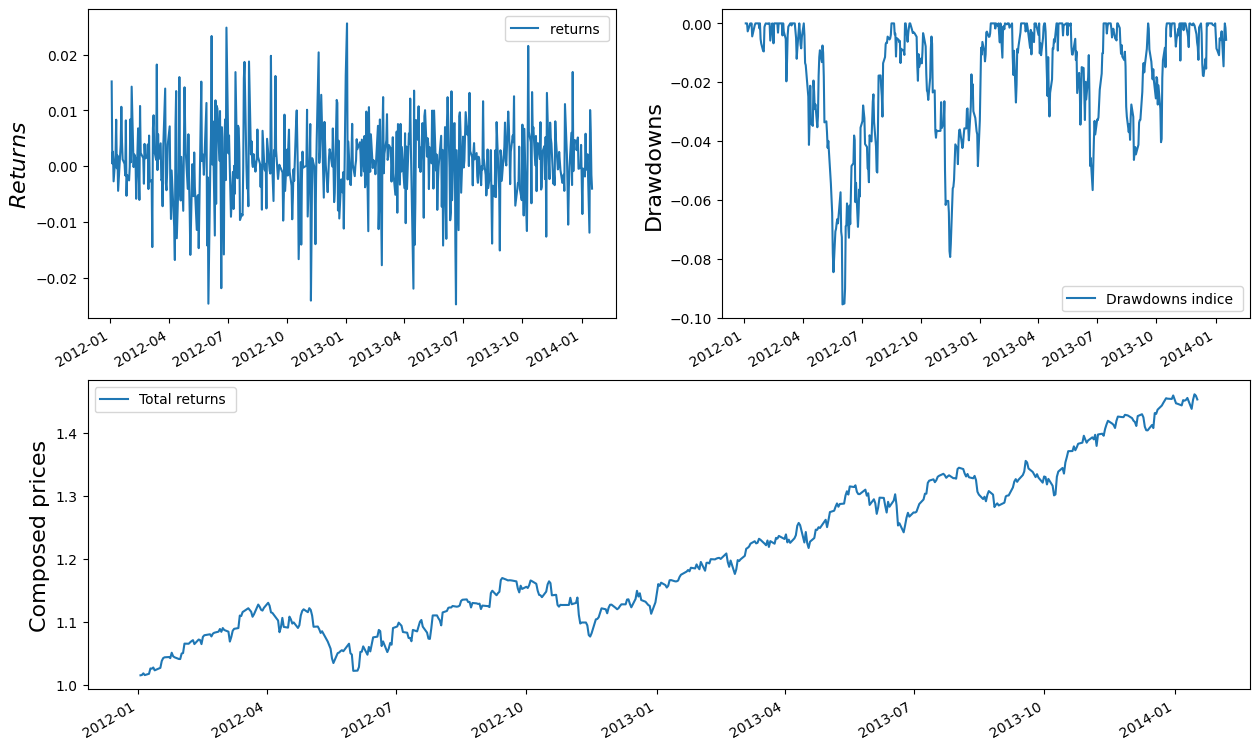

In [99]:
ev = evaluation(r, 3)
plt.savefig("images/rsp300_graph.png")

## Robuste

In [162]:


# robuste 

def W_ROBUSTE (mu, vol, Sigma, lmbda, kapa):
    
    # Define variables
    w = cp.Variable(len(mu)) # portfolio weights
    
    Omega = np.diag(vol)
   
    # Define objective function
    objective = cp.Maximize(mu @ w - kapa * cp.norm(Omega@ w , 2) - lmbda * cp.quad_form(w, Sigma))

    # Define constraints
    constraints = [cp.sum(w) == 1, w >= 0] # fully invested, long-only portfolio

    # Solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Return results
    w_opt = w.value
    
    return w_opt
    

In [190]:

#Compute a fonction that calculate the returns each when we change the weigth each month 
# choosing n best companies in our weigth

def robust_compute_returns(returns, start_date, end_date, n, lmbda, kapa):
    

         
    
    result = pd.DataFrame()    
    start_period = start_date
    end_period = start_period + timedelta(days=30)
        
    while start_period < end_date:
        
        companies = best_companies(start_period, new_weight, n)

        matrice_returns = returns_period(returns, start_period - timedelta(days=730), start_period, companies)


        mu = matrice_returns.mean(axis=0).to_numpy()
        Sigma = matrice_returns.corr() * np.dot(np.array([matrice_returns.std()]).T,np.array([matrice_returns.std()]))
        vol =  matrice_returns.std().to_numpy()
        
        #check if Sigma SPD
        
        if test(Sigma):
            w = W_ROBUSTE(mu,vol, Sigma, lmbda, kapa)
            w = np.round(w*10**10)/10**10
        else : 
           
            drop = matrice_returns.columns[matrice_returns.isna().any()]
            companies = matrice_returns.columns.drop(drop)
            
            matrice_returns = matrice_returns[companies]

            vol =  matrice_returns.std().to_numpy()
            mu = matrice_returns.mean(axis=0).to_numpy()
            Sigma = matrice_returns.corr() * np.dot(np.array([matrice_returns.std()]).T,np.array([matrice_returns.std()]))
            
            w = W_ROBUSTE(mu,vol, Sigma, lmbda, kapa)
            w = np.round(w*10**10)/10**10


        
        r = returns_period(returns, start_period, end_period, companies)
        
        month_return = (r * w).sum(axis=1)
        
        result = pd.concat([result,month_return])
    
        
        start_period = end_period
        end_period = end_period + timedelta(days=30)
        
    result.index = pd.to_datetime(result.index)
    result.columns = ["Returns"]
    
    return result
            
        

,time_period,$\mu$,$\mu_{an}$,$\sigma$,$\sigma_{an}$,Sharpe_Ratio,Max_Drawdown,VaR_95%
rS&P 300,2008-1 / 2010-1,-0.01864%,-4.590%,2.227%,35.346%,-0.008373,-52.392%,-3.361%
MVO,2008-1 / 2010-1,-0.05875%,-13.765%,1.482%,23.521%,-0.039651,-44.952%,-2.571%


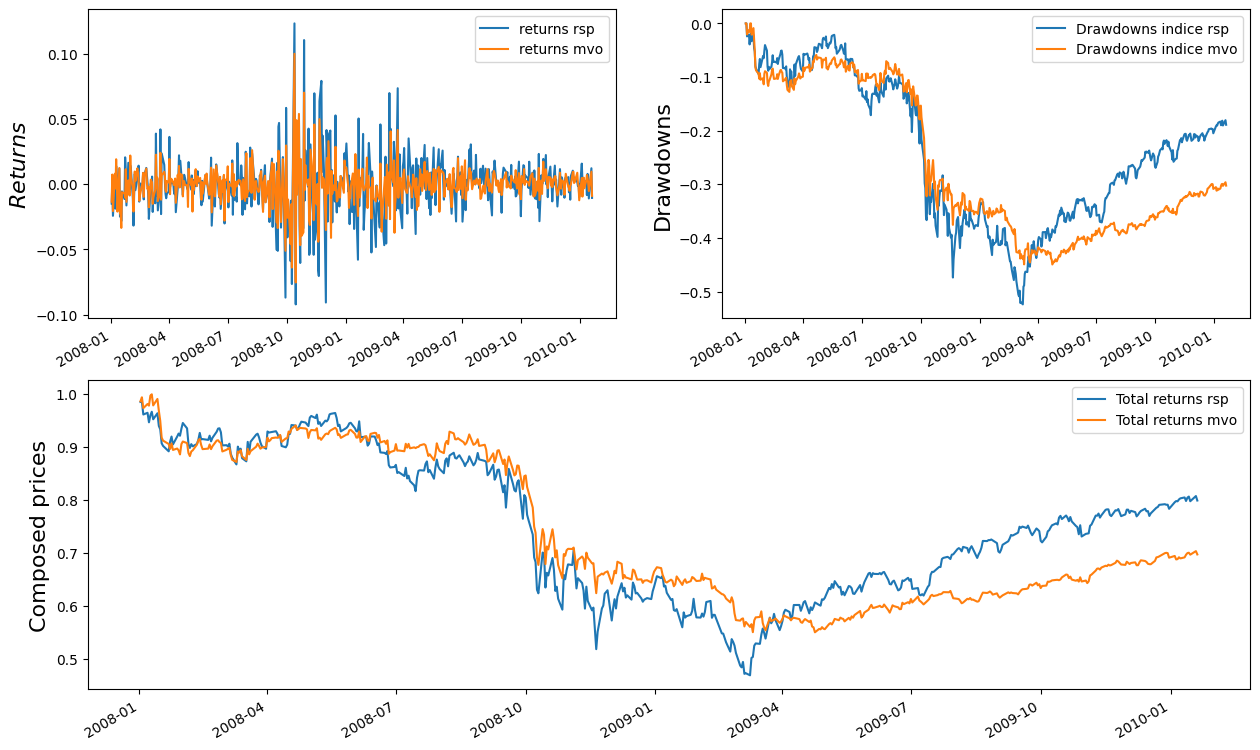

In [212]:
s = pd.Timestamp("2008")
e = s + timedelta(days=730)

r = rsp_compute_returns(Returns, s, e, 530)
r2 = MVO_compute_returns(Returns, s, e, 100, lmbda=10)
#r3 = MVO_compute_returns(Returns, s, e, 100, lmbda=10, sum_one=False, positive=False)
#r4 = robust_compute_returns(Returns, s, e, 100, 1/2, 0.25)

ev = evaluation(r, 2, "rsp")
ev2 = evaluation(r2, 2, "mvo")
#ev3 = evaluation(r3, 2, "neg")
#ev4  = evaluation(r4, 2, "rob")


x = display_result(['rS&P 300', 'MVO'], [ev, ev2]) 
x

In [ ]:
plot_Drawdown(r["Returns"], 1, "rsp")
plot_Drawdown(r2["Returns"], 1, "MVO")
plot_tot_returns(r["Returns"], 2, "rsp")
plot_tot_returns(r2["Returns"], 2, "MVO")


# Markovic
